In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Data from training log
global_step = np.array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000])
mse_distributed = np.array([0.0102, 0.0061, 0.0046, 0.0054, 0.0037, 0.0040, 0.0032, 0.0021, 0.0040, 0.0039, 0.0032, 0.0025, 0.0036, 0.0026, 0.0021, 0.0033, 0.0052, 0.0033, 0.0015, 0.0096, 0.0019, 0.0019, 0.0024, 0.0034, 0.0020, 0.0029, 0.0052, 0.0017, 0.0031, 0.0028, 0.0025, 0.0027, 0.0037, 0.0015, 0.0017, 0.0045, 0.0017, 0.0018, 0.0033, 0.0021, 0.0056, 0.0016, 0.0045, 0.0027, 0.0031, 0.0026, 0.0053, 0.0050, 0.0052, 0.0022])
mse_centralized = np.array([0.0084, 0.0099, 0.0067, 0.0102, 0.0058, 0.0088, 0.0025, 0.0089, 0.0021, 0.0044, 0.0053, 0.0036, 0.0025, 0.0025, 0.0022, 0.0044, 0.0026, 0.0026, 0.0029, 0.0039, 0.0038, 0.0036, 0.0030, 0.0014, 0.0031, 0.0039, 0.0030, 0.0016, 0.0113, 0.0017, 0.0021, 0.0019, 0.0055, 0.0025, 0.0054, 0.0020, 0.0038, 0.0031, 0.0024, 0.0066, 0.0019, 0.0013, 0.0022, 0.0015, 0.0051, 0.0042, 0.0019, 0.0022, 0.0015, 0.0020])
distributed_time_step = np.array([0.19, 0.38, 0.57, 0.75, 0.94, 1.13, 1.31, 1.51, 1.71, 1.89, 2.08, 2.27, 2.45, 2.64, 2.83, 3.01, 3.21, 3.41, 3.62, 3.80, 3.99, 4.19, 4.38, 4.56, 4.75, 4.94, 5.12, 5.31, 5.50, 5.69, 5.88, 6.06, 6.25, 6.43, 6.62, 6.81, 6.99, 7.18, 7.36, 7.55, 7.74, 7.92, 8.11, 8.29, 8.48, 8.67, 8.85, 9.04, 9.24, 9.42])
centralized_time_step = np.array([0.23, 0.46, 0.69, 0.92, 1.15, 1.39, 1.62, 1.85, 2.09, 2.32, 2.55, 2.78, 3.01, 3.37, 3.60, 3.83, 4.06, 4.29, 4.52, 4.75, 4.98, 5.21, 5.44, 5.67, 5.90, 6.14, 6.36, 6.59, 6.82, 7.06, 7.29, 7.52, 7.75, 7.98, 8.20, 8.44, 8.67, 8.90, 9.13, 9.36, 9.59, 9.82, 10.05, 10.30, 10.54, 10.78, 11.01, 11.24, 11.47, 11.70])

In [3]:
# Parameters
threshold = 0.001  # Threshold for stability
window_size = 3   # Window size for smoothing the rate of change
sustained_steps = 3  # Number of consecutive windows to confirm plateau

In [4]:
# Function to smooth data and find plateau index
def find_plateau_with_cumulative_check(mse, steps, threshold, window_size, sustained_steps):
    
    # Smooth the MSE values
    smoothed_mse = np.convolve(mse, np.ones(window_size)/window_size, mode='valid')
    
    # Compute rate of change
    rate_of_change = np.abs(np.diff(smoothed_mse))
    
    # Check when cumulative average rate of change stays below threshold
    for i in range(len(rate_of_change) - sustained_steps + 1):
        if np.all(rate_of_change[i:i + sustained_steps] < threshold):
            return steps[i + window_size + sustained_steps - 1]  # Map to global step
            
    return None  # No plateau found

In [5]:
# Detect plateaus for both models
distributed_plateau_step = find_plateau_with_cumulative_check(mse_distributed, global_step, threshold, window_size, sustained_steps)
centralized_plateau_step = find_plateau_with_cumulative_check(mse_centralized, global_step, threshold, window_size, sustained_steps)
 
# Output
print("Distributed Plateau Step:", distributed_plateau_step)
print("Centralized Plateau Step:", centralized_plateau_step)

Distributed Plateau Step: 7000
Centralized Plateau Step: 14000


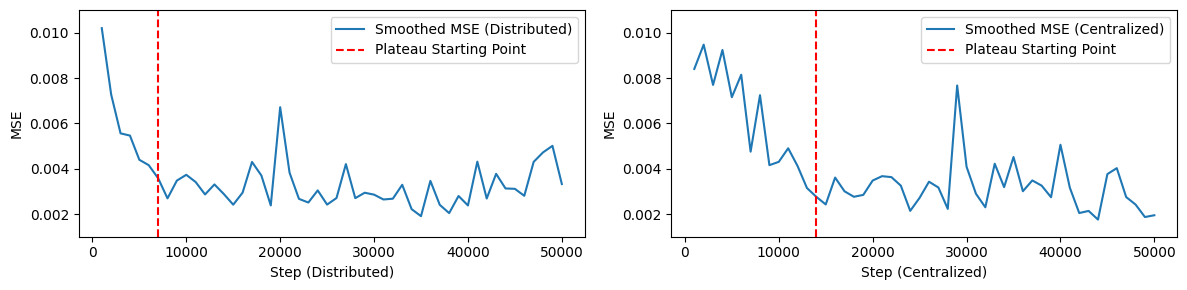

In [6]:
# Locate plateau points
distributed_plateau_idx = (np.where(global_step==distributed_plateau_step)[0])[0]
centralized_plateau_idx = (np.where(global_step==centralized_plateau_step)[0])[0]

# Data smoothing using exponential moving average
alpha = 0.6
smoothed_mse_distributed = pd.Series(mse_distributed).ewm(alpha=alpha).mean().to_numpy()
smoothed_mse_centralized = pd.Series(mse_centralized).ewm(alpha=alpha).mean().to_numpy()

# Plotting
plt.figure(figsize=(12, 3))
 
plt.subplot(1, 2, 1)
plt.plot(global_step, smoothed_mse_distributed, label='Smoothed MSE (Distributed)')
plt.axvline(x=global_step[distributed_plateau_idx], color='r', linestyle='--', label='Plateau Starting Point')
plt.xlabel('Step (Distributed)')
plt.ylabel('MSE')
plt.ylim([0.001, 0.011])
plt.legend()
 
plt.subplot(1, 2, 2)
plt.plot(global_step, smoothed_mse_centralized, label='Smoothed MSE (Centralized)')
plt.axvline(x=global_step[centralized_plateau_idx], color='r', linestyle='--', label='Plateau Starting Point')
plt.xlabel('Step (Centralized)')
plt.ylabel('MSE')
plt.ylim([0.001, 0.011])
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
def convergence_stability(global_step, mse_values, p, q):
    
    start_index = np.where(global_step >= p)[0][0]
    end_index = np.where(global_step <= q)[0][-1] + 1
    window_values = mse_values[start_index:end_index]
    window_mean = np.mean(window_values)
    abs_differences = np.abs(window_values - window_mean)
    stability = np.mean(abs_differences)
    
    return np.round(stability,4)

In [8]:
p, q = distributed_plateau_step, global_step[-1]  # Example single window from 7k to 50k
distributed_convergence_stability = convergence_stability(global_step, mse_distributed, p, q)
print("Distributed Stability:", distributed_convergence_stability)

p, q = centralized_plateau_step, global_step[-1]  # Example single window from 7k to 50k
centralized_convergence_stabiloity = convergence_stability(global_step, mse_centralized, p, q)
print("Centralized Stability:", centralized_convergence_stabiloity)

Distributed Stability: 0.0011
Centralized Stability: 0.0013
